In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers

from tqdm import tqdm

# import glob
# import imageio
# import os
# import PIL
# import time

tf.__version__
tf.keras.backend.set_floatx('float32')

In [15]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = (train_images-127.5)/127.5

train_images = np.stack((train_images, train_images, train_images), axis=3)
train_images_color = train_images.copy()
# train_images_color[train_images>0] = np.random.uniform(0, 255, train_images_color[train_images>0].shape)
train_images_color[:, :, :, 1] = -1
train_images_color[:, :, :, 2] = -1

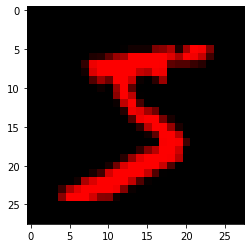

In [19]:
plt.imshow(train_images_color[0]/2+0.5)

In [51]:
# A space is the original space
# B space is the color space

def create_generator_model_A2B():
    gm = tf.keras.Sequential()
    gm.add(layers.Flatten(input_shape=(28, 28, 3)))
    gm.add(layers.Dense(28*28*3, activation='tanh'))
    gm.add(layers.Reshape((28, 28, 3)))
    assert gm.output_shape == (None, 28, 28, 3)
    
    
#     gm.add(layers.Conv2D(100, (5,5), strides=(1,1), padding='same', use_bias=False))
    
    
    
#     gm.add(layers.Dense(7*7*256, use_bias=False, input_shape=(28, 28, 3)))
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Reshape((7, 7, 256)))
#     assert gm.output_shape == (None, 7, 7, 256) # Note: None is the batch size

#     gm.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert gm.output_shape == (None, 7, 7, 128)
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert gm.output_shape == (None, 14, 14, 64)
#     gm.add(layers.BatchNormalization())
#     gm.add(layers.LeakyReLU())

#     gm.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert gm.output_shape == (None, 28, 28, 3)

    return gm
    
def create_generator_model_B2A():
    return create_generator_model_A2B()


def create_discriminator_model_A():
    dm = tf.keras.Sequential()
    dm.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    dm.add(layers.LeakyReLU())
    dm.add(layers.Dropout(0.3))

    dm.add(layers.Flatten())
    dm.add(layers.Dense(1))
    return dm

def create_discriminator_model_B():
    return create_discriminator_model_A()


In [52]:
gm_a2b = create_generator_model_A2B()
gm_b2a = create_generator_model_B2A()

dm_a = create_discriminator_model_A()
dm_b = create_discriminator_model_B()

W0405 21:08:53.364359 4499627456 base_layer.py:1790] Layer flatten_12 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0405 21:08:53.390339 4499627456 base_layer.py:1790] Layer flatten_13 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floa

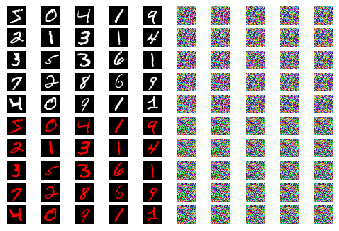

In [53]:
rows = 5
columns = 5
# vis_noises = np.random.normal(0, 1, (rows*columns, 100))

def show_generator_model_images(gm_a2b, gm_b2a):
    real_a = train_images[:rows*columns]
    real_b = train_images_color[:rows*columns]
    fake_b = gm_a2b(real_a, training=False)
    fake_a = gm_b2a(real_b, training=False)
    

    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1)
            plt.imshow(real_a[column+row*columns]/2+0.5)
            plt.axis('off')
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+rows*columns*2)
            plt.imshow(real_b[column+row*columns]/2+0.5)
            plt.axis('off')
            
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+columns)
            plt.imshow(fake_b[column+row*columns]/2+0.5)
            plt.axis('off')
    for row in range(rows):
        for column in range(columns):
            plt.subplot(2*rows, 2*columns, column+row*(2*columns)+1+rows*columns*2+columns)
            plt.imshow(fake_a[column+row*columns]/2+0.5)
            plt.axis('off')
    
    
#     for i in range(4*rows*columns):
#         plt.subplot(2*rows, 2*columns, i+1)
#         row = i / (2*columns)
#         column = i % (2*columns)
#         if column < columns: 
#             if row < rows:
#             plt.imshow(real_a, cmap='gray')
#             # plt.colorbar()
#             plt.axis('off')
    
    
show_generator_model_images(gm_a2b, gm_b2a)

In [54]:
g_a2b_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
g_b2a_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_a_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_b_optim = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [55]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()
# mean_square_error = tf.keras.losses.MeanSquaredError()

def cycle_loss(ori_img, cycle_img):
    return mean_absolute_error(ori_img, cycle_img)
def identity_loss(ori_img, same_img):
    return mean_absolute_error(ori_img, same_img)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # want to correctly identify real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # want to correctly identify fake
    return real_loss + fake_loss


In [56]:
@tf.function
def train_step(a_image_batch, b_image_batch):    
    # gradient tapes needed to keep track of gradients (auto differentiation)
    with tf.GradientTape() as tape:
        # aba cycle
        fake_b = gm_a2b(a_image_batch, training=True)
        cycle_a = gm_b2a(fake_b, training=True)
        
        # bab cycle
        fake_a = gm_b2a(b_image_batch, training=True)
        cycle_b = gm_a2b(fake_a, training=True)
        
        # identity
        same_a = gm_b2a(a_image_batch, training=True)
        same_b = gm_a2b(b_image_batch, training=True)
        
        real_output_a = dm_a(a_image_batch, training=True)
        fake_output_a = dm_a(fake_a, training=True)
        real_output_b = dm_b(b_image_batch, training=True)
        fake_output_b = dm_b(fake_b, training=True)
        
        d_loss_a = discriminator_loss(real_output_a, fake_output_a)
        d_loss_b = discriminator_loss(real_output_b, fake_output_b)
        
        c_loss = cycle_loss(a_image_batch, cycle_a) + cycle_loss(b_image_batch, cycle_b)
        i_loss_a = identity_loss(a_image_batch, same_a)
        i_loss_b = identity_loss(b_image_batch, same_b)
        
        g_loss_a2b = generator_loss(fake_output_b) + i_loss_a + c_loss
        g_loss_b2a = generator_loss(fake_output_a) + i_loss_b + c_loss

    grad_a2b = tape.gradient(g_loss_a2b, gm_a2b.trainable_variables)
    grad_b2a = tape.gradient(g_loss_b2a, gm_b2a.trainable_variables)
    grad_da = tape.gradient(d_loss_a, dm_a.trainable_variables)
    grad_db = tape.gradient(d_loss_b, dm_b.trainable_variables)
    
    a_optim.apply_gradients(zip(a_grad, am.trainable_variables))
    b_optim.apply_gradients(zip(b_grad, bm.trainable_variables))
    
    g_a2b_optim.apply_gradients(zip(grad_a2b, gm_a2b.trainable_variables))
    g_b2a_optim.apply_gradients(zip(grad_b2a, gm_b2a.trainable_variables))
    d_a_optim.apply_gradients(zip(grad_da, dm_a.trainable_variables))
    d_b_optim.apply_gradients(zip(grad_db, dm_b.trainable_variables))

In [ ]:
batch_size = 100

def train(images, epochs):
    for epoch in range(epochs):
        
        for i_batch in tqdm(range(int(images.shape[0]/batch_size))):
            a_image_batch = images[i_batch*batch_size:(i_batch+1)*batch_size]
            b_image_batch = images[i_batch*batch_size:(i_batch+1)*batch_size]
            train_step(image_batch)
            
            if i_batch%10==0:
                show_generator_model_images(gm)
                plt.savefig(f'mnist_gan/epoch_{epoch:03d}_step_{i_batch:03d}')
                plt.close()
